In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

# A real-world example

We're going to take a look at data on COVID coverage by local news agencies in the US.

There are a number of features in this dataset, there's a more detailed description of most of them [here](https://arxiv.org/pdf/2111.08515.pdf). I'll describe what we're using here, though, obviusly

*Note: I am, again, using data that I have used for research in the past. I think it is useful, because I am able to provide more thoughtful responses to questions and comments about the data and methods. It is not because I think my research is especially great, or that you should read it.*

In [32]:
covid_df = pd.read_csv("covid_local_news.csv")

## Walking the ML Pipeline



In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://www-student.cse.buffalo.edu/~atri/algo-and-society/support/notes/pipeline/images/ML-pipeline-duame-soc.png",
     width=800)


In [4]:
Image(url="https://pbs.twimg.com/media/FKtEyl5XEAABdEa?format=jpg&name=4096x4096", width=800)

### Real world goal

Find local news deserts. In other words, find places where people aren('t) likely to be getting adequate news about COVID


### Real world mechanism

Identify places where **<span style="color:red">the number of articles that cover COVID</span>** is low. We can then try to forecast coverage in locations where we don't have data.



In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./coverage.png", width=600, height=600)

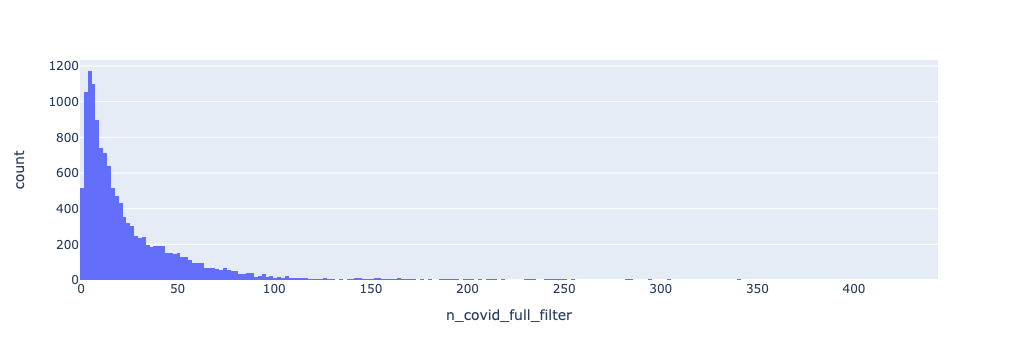

In [6]:
px.histogram(covid_df, x="n_covid_full_filter")

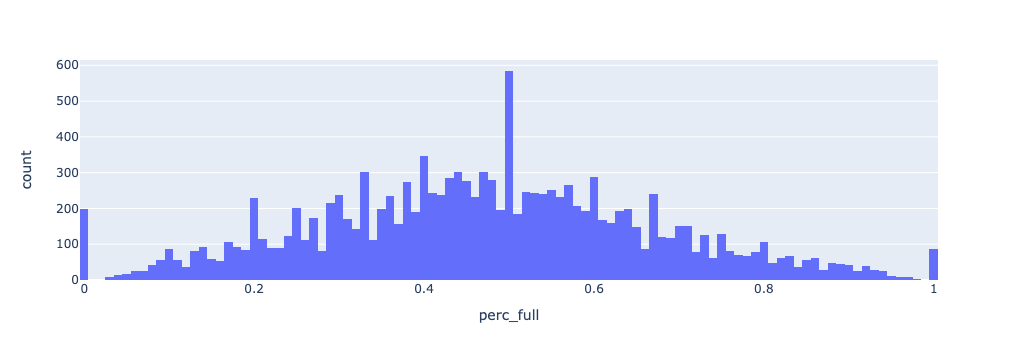

In [7]:
px.histogram(covid_df, x="perc_full")

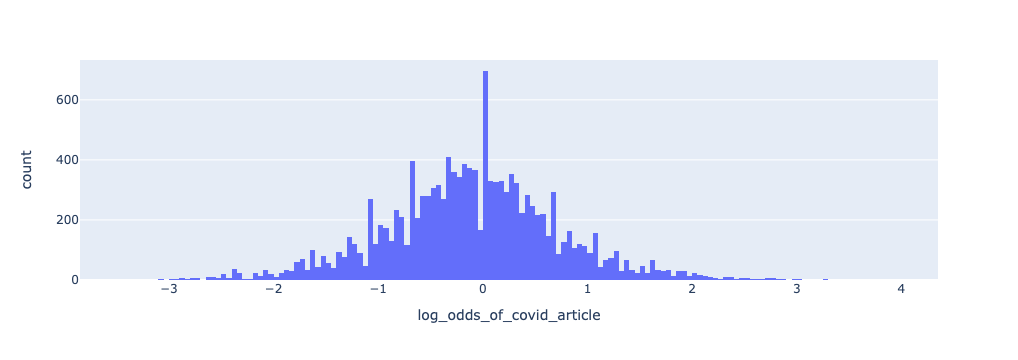

In [36]:
covid_df['log_odds_of_covid_article'] = np.log((covid_df.n_covid_full_filter+1)/(covid_df.n_total_articles-covid_df.n_covid_full_filter+1))
px.histogram(covid_df, x="log_odds_of_covid_article")

## Learning problem

Predict the percentage of weekly coverage devoted to COVID for local news outlets across the country that make data available

## Data Collection

- RSS Feeds (You can have data like this, [from here](https://benjamindhorne.github.io/data.html). We might play with some later in the semester)
- U.S. Census Bureau
- A bunch of random Githubs :)

## Data Representation

In [148]:
pd.set_option('display.max_columns', None)
covid_df.head()

fips_full  fips    state  week_num  fips_covid  \
0       1013  1013  Alabama        14        1013   
1       1013  1013  Alabama        15        1013   
2       1013  1013  Alabama        16        1013   
3       1013  1013  Alabama        17        1013   
4       1013  1013  Alabama        18        1013   

                             sourcedomain_id        lon        lat  \
0  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
1  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
2  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
3  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   
4  greenvilleadvocate-greenvilleadvocate.com -86.617752  31.829597   

                     title       rank  n_total_articles  \
0  The Greenville Advocate  1510346.0                 4   
1  The Greenville Advocate  1510346.0                11   
2  The Greenville Advocate  1510346.0                 1   
3  The Greenville Advocate  1510346.0                12   
4  The Greenville Advocate  1510346.0                 3   

   n_covid_limited_filter  n_covid_full_filter  fips_cum_cases  \
0                       2                    4               8   
1                       1                    7              16   
2                       0                    1              45   
3                       3                    7             120   
4                       1                    3             224   

   fips_cum_deaths  fips_lag1_cum_cases  fips_lag2_cum_cases  fips_n_cases  \
0                0                    2                    1             6   
1                0                    8                    2             8   
2                1                   16                    8            29   
3                2                   45                   16            75   
4                6                  120                   45           104   

   fips_lag1_n_cases  fips_lag1_cum_deaths  fips_lag2_cum_deaths  \
0                  1                     0                     0   
1                  6                     0                     0   
2                  8                     0                     0   
3                 29                     1                     0   
4                 75                     2                     1   

   fips_n_deaths  fips_lag1_n_deaths  state_cum_cases  state_cum_deaths  \
0              0                   0             3955               115   
1              0                   0             5350               195   
2              1                   0             6752               245   
3              1                   1             8438               317   
4              4                   1            10464               436   

   state_lag1_cum_cases  state_lag2_cum_cases  state_n_cases  \
0                  2200                  1008           1755   
1                  3955                  2200           1395   
2                  5350                  3955           1402   
3                  6752                  5350           1686   
4                  8438                  6752           2026   

   state_lag1_n_cases  state_lag1_cum_deaths  state_lag2_cum_deaths  \
0                1192                     64                     14   
1                1755                    115                     64   
2                1395                    195                    115   
3                1402                    245                    195   
4                1686                    317                    245   

   state_n_deaths  state_lag1_n_deaths country  country_cum_cases  \
0              51                   50     USA             604363   
1              80                   51     USA             804845   
2              50                   80     USA            1012453   
3              72                   50     USA            1203928   
4             119        

## (Modded sp?) Pipeline - Let's do some EDA!

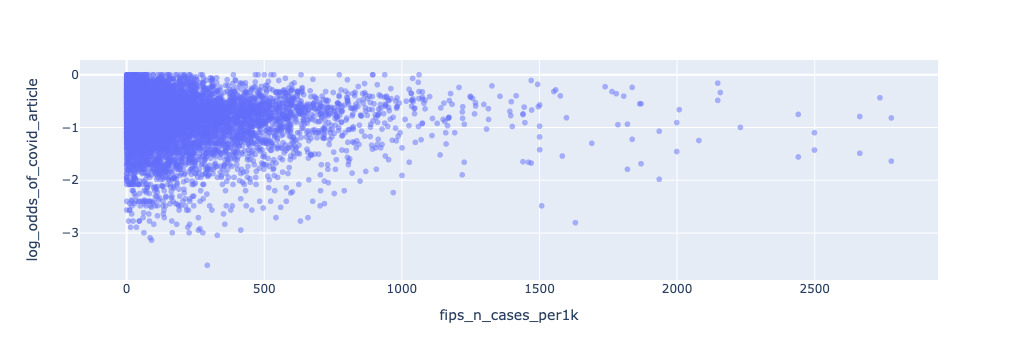

In [16]:
px.scatter(covid_df.sample(10000),
           x='fips_n_cases_per1k_log',
           y='log_odds_of_covid_article',
           opacity=.5
           )

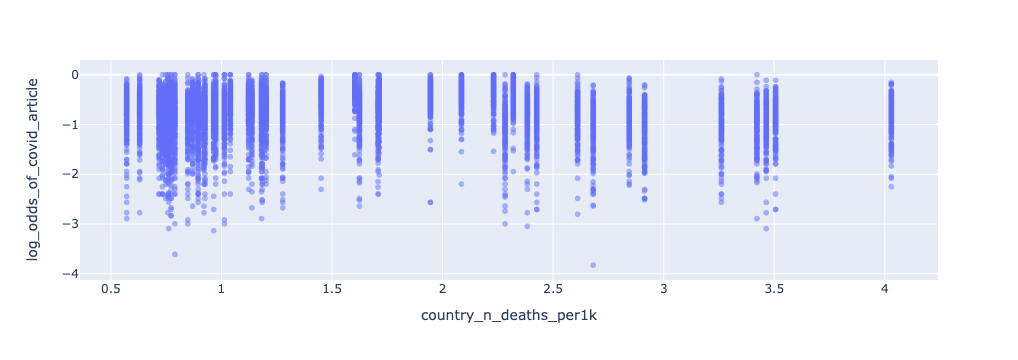

In [20]:
px.scatter(covid_df.sample(10000),
           x='country_n_deaths_per1k',
           y='log_odds_of_covid_article',
           opacity=.5
           )

In [21]:
from scipy.stats import pearsonr

pearsonr(covid_df.country_n_deaths_per1k, covid_df.log_odds_of_covid_article )

(-0.04869514360602452, 1.5869820562104472e-08)

In [22]:
pearsonr(covid_df.fips_n_deaths_per1k, covid_df.log_odds_of_covid_article )

(-0.022215429530362464, 0.009958701688477182)

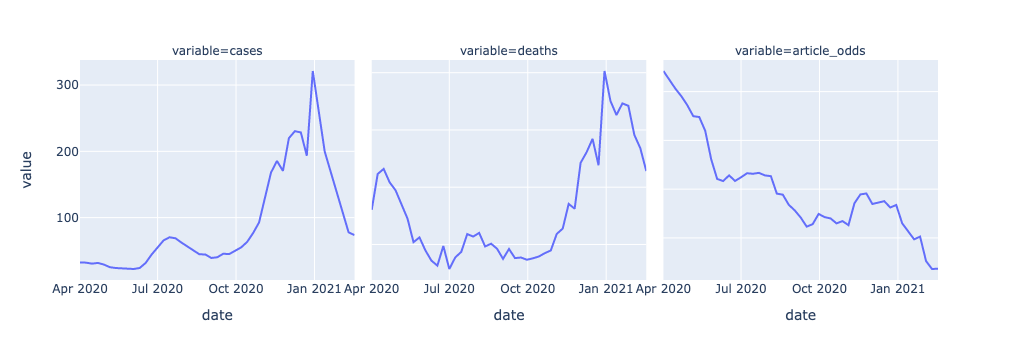

In [31]:
averaged_data = covid_df.groupby("date").agg(
        cases = pd.NamedAgg("country_n_cases_per1k","first"),
        deaths = pd.NamedAgg("country_n_deaths_per1k","first"),
        article_odds = pd.NamedAgg("log_odds_of_covid_article","mean")
).reset_index()
fig = px.line(pd.melt(averaged_data,id_vars="date"),x="date",y="value",facet_col="variable")
fig.update_yaxes(matches=None)
fig.show()

## Target Class/Model

Linear regression. Now we know what that is! And how to optimize it (although we'll use the `sklearn` implementation 

## Training dataset


### Picking a "good" training dataset ... getting us started
Next week, we'll cover model evaluation in more detail. For now, we're just going to note that to ensure our model is generalizable and not overfit to the training data, we need to separate out a training dataset from a test dataset.

**Exercise:** Give a high-level argument for why evaluating on the training data is a bad idea

With *temporal* data, and more generally, data with dependencies, it is also important that we make sure that we are avoiding the leakage of information from the training data in a way that creates a biased understanding of how well we are making predictions. Leakage can happen in at least two ways (again, we'll go into more detail next week):

- We have a feature for a given exmple that wouldn't be available in the real world **exercise:** what's an example here?
- (The trickier one, and informally) We use training data that is somehow correlated with the test data in ways that reveal a pattern to the model that it would not otherwise know. (I'll give an example here).


For this simple example, for now, we're going to ignore the leakage issue. We'll come back and fix that next week

### Picking ... a dataset

Neat! But to pick a good training dataset, we first need to know ... what our dataset is. This data has *a lot* of features. In class, we'll play with a bunch of them, together. Here, I'm just going to get us started

In [41]:
CONTINUOUS_FEATURES = ["state_lag1_n_cases_per1k",
"fips_lag1_n_cases_per1k",
"country_lag1_n_cases_per1k",
"predrt_0"]

OUTCOME = 'log_odds_of_covid_article'


X = covid_df[CONTINUOUS_FEATURES]
y = covid_df[OUTCOME]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

## Model training

OK, let's have at it!


In [43]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

# Predict on Test Data


In [44]:
predictions = model.predict(X_test)

# Evaluate error

In [45]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,predictions)

0.6643640375053314

# Deploy (?)

What might we be asking ourselves before we deploy?  What might we try to change? Let's work on it!

**In class exercise ... beat Kenny's predictive model!**

# For some reason not in the pipeline ... evaluating coefficients ...

We have to be really careful when *interpreting coefficients for models with transformed predictor variables*. [Here, for example, is a useful resource for your programming assignment](https://cscu.cornell.edu/wp-content/uploads/83_logv.pdf).

In our case, we actually ended up using a variable that means interpreting our coefficients using interpretations for logistic regression. [Here](https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) is a good explanation. We will cover this in more detail next week, but a simple plot below to discuss!

**Exercise:** Are the estimates from the coefficients we used comparable? Which are, and which are not? What might we do to make them even more comparable?

For this demo, I took code from [this sklearn tutorial](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html). The tutorial is very nice, I would highly recommend going through it, although *I will teach most of what is in this over the next week or two in one way or another*.

In [52]:
feature_names = CONTINUOUS_FEATURES

coefs = pd.DataFrame(
    model.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

Coefficients
state_lag1_n_cases_per1k        0.000557
fips_lag1_n_cases_per1k        -0.000172
country_lag1_n_cases_per1k     -0.002770
predrt_0                       -0.013255

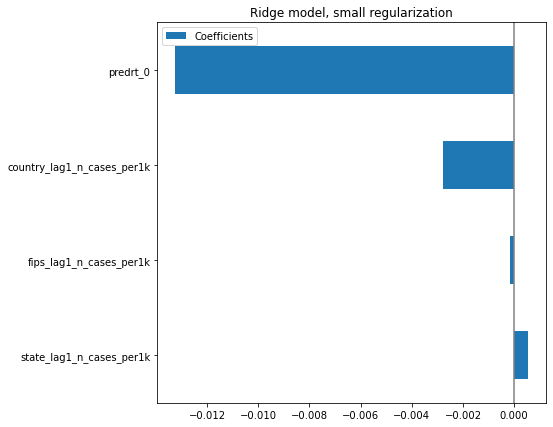

In [53]:
import matplotlib.pyplot as plt
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [55]:
coefs['odds_ratio'] = np.exp(coefs.Coefficients)

In [56]:
coefs

Coefficients  odds_ratio
state_lag1_n_cases_per1k        0.000557    1.000557
fips_lag1_n_cases_per1k        -0.000172    0.999828
country_lag1_n_cases_per1k     -0.002770    0.997234
predrt_0                       -0.013255    0.986832